# The Professionalisation of Airbnb in London

## Front Matter
__Module Name:__ Introduction to Programming for Spatial Analysts \
__Module Number:__ CASA0013 \
__Student Number:__ 15043876 

## Executive Briefing

With the government’s crackdown on the private rented sector putting some landlords off, Airbnb and similar short-term letting options can provide a lucrative alternative.

## Reproducible Analysis

In [137]:
# This loads all the packages that will be used for the analysis
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from requests import get
from urllib.parse import urlparse

#This resets plotting stylesheet
mpl.rcParams.update(mpl.rcParamsDefault)


In [138]:
#defining a function that reads and downloads data to save locally

def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

### Loading the Airbnb data

To get an accurate picture of how Airbnb is operating today, We want to download the most recent dataset available. In our case, this is from the 6th of November 2020. It could be interesting to look at whether the coronavirus pandemic has influenced the prevalnce of "proffessional" airbnb lettings as tourism numbers have declined

In [167]:
# Read the raw data and save it locally
ddir  = os.path.join('data','raw') # create a destination directory where the data will be stored
path = 'https://github.com/signesw/i2p_coursework/blob/main/source_data/' # source path

# read the csv
listings = pd.read_csv( cache_data(path+'listings.csv.gz?raw=true', ddir),
    compression='gzip', low_memory=False)

# print dataframe
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Found data/raw/listings.csv.gz locally!
Data frame is 76,984 x 74


In [168]:
# We're going to reload the listings, with just the columns we're interested in 
for col in listings.columns: 
    print(col) 
del(listings)

id
listing_url
scrape_id
last_scraped
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
review_sc

In [169]:
# Lets just look at the columns we're interested in
cols = ['id','price','latitude','longitude',
        'host_id','host_name','host_since','property_type','room_type',
        'accommodates','number_of_reviews','availability_365','calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms','license']

listings  = pd.read_csv("data/raw/listings.csv.gz",usecols=cols,low_memory=False)

print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 76,984 x 17


In [142]:
#Let's have a look at the data
listings.head()

,id,host_id,host_name,host_since,latitude,longitude,property_type,room_type,accommodates,price,availability_365,number_of_reviews,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,11551,43039,Adriano,2009-10-03,51.46225,-0.11732,Entire apartment,Entire home/apt,4,$97.00,279,192,2,2,0,0
1,13913,54730,Alina,2009-11-16,51.56802,-0.11121,Private room in apartment,Private room,2,$40.00,365,21,2,1,1,0
2,15400,60302,Philippa,2009-12-05,51.48796,-0.16898,Entire apartment,Entire home/apt,2,$75.00,150,89,1,1,0,0
3,17402,67564,Liz,2010-01-04,51.52195,-0.14094,Entire apartment,Entire home/apt,6,$307.00,330,42,15,15,0,0
4,17506,67915,Charlotte,2010-01-05,51.47935,-0.19743,Private room in bed and breakfast,Private room,2,$150.00,364,0,2,0,2,0


### Let's first look at all the properties currently listed in London
We will want to load some geodata on which we can map our listings. Here we will download and save a geopackage for the London Boroughs shapefile. The data has been downloaded from the [London Data Store](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london), provided as a GIS shapefile. For ease of the reproducible analysis, the shapefile has first been converted to a geopackage and saved in the [github repository](https://github.com/signesw/i2p_coursework/tree/main/source_data) for this project. 

In [144]:
directory = os.path.join('data','geo') # destination directory
spath = "https://github.com/signesw/i2p_coursework/blob/main/source_data/boroughs.gpkg?raw=true" # source path

London = gpd.read_file( cache_data(spath, directory) ) # reading and saving file locally if not already there

Found data/geo/boroughs.gpkg locally!


Let's have a look at the map, just to check the geopackage has been loaded correctly. First, we want to reporject the map into the OSGB36 peojection, the most common cooridnate reference system for UK data. 

<AxesSubplot:>

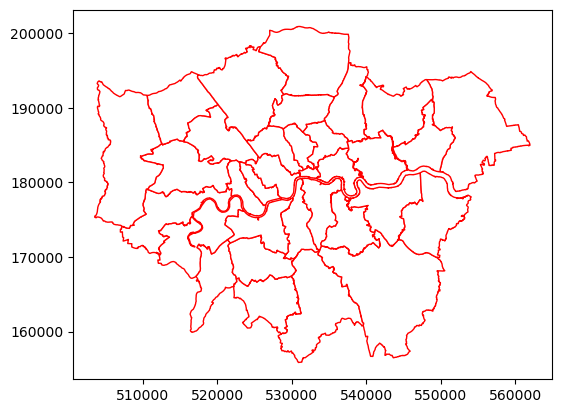

In [145]:
# Let's reproject into OSGB36
London = London.to_crs('EPSG:27700')

London.plot(edgecolor="red", facecolor="white", linewidth=1)


### Mapping out Airbnb Locations
Now we want to plot our AirBnb points onto the map.
The listings data has longitude and latitude coordinates, coordinates, so we can convert our data to a geodataframe. First though, we need to do some data cleaning to ensure there are no issues when converting to a geodataframe. 

In [146]:
#we want to drop the rows where longitude and latitude are na values, as this will cause issues when converting to dataframe
listings.drop(listings[listings.latitude.isna()].index.values, axis=0, inplace=True)
listings.drop(listings[listings.longitude.isna()].index.values, axis=0, inplace=True)
print(f"listings dataframe now contains {listings.shape[0]} rows.")

listings dataframe now contains 76984 rows.


It looks like no rows were dropped, meaning that the dataset was complete

In [148]:
# turning our listings data to geodata using long and lat and saving locally as geopackage

listings_geo = gpd.GeoDataFrame(listings, 
      geometry=gpd.points_from_xy(listings['longitude'], listings['latitude'], crs='epsg:4326'))

listings_geo.to_file('data/geo/listings.gpkg', driver="GPKG")

We want our listings dataframe to be in the same CRS as our basemap, so we check the projection and reproject

In [149]:
# check CRS and reproject

if listings_geo.geometry.crs != 'EPSG:27700':
    print(f" Different CRS: {listings_geo.geometry.crs}, reprojecting...")
    listings_geo=listings_geo.to_crs('EPSG:27700')
    print(f" CRS After reprojecting: {listings_geo.geometry.crs}")
else:
    print("No reprojection necessary, Listings CRS same as Boroughs geopackage")


 Different CRS: epsg:4326, reprojecting...
 CRS After reprojecting: EPSG:27700


 Now we are ready to plot the points onto our London basemap

(501000.0, 563000.0, 155000.0, 202000.0)

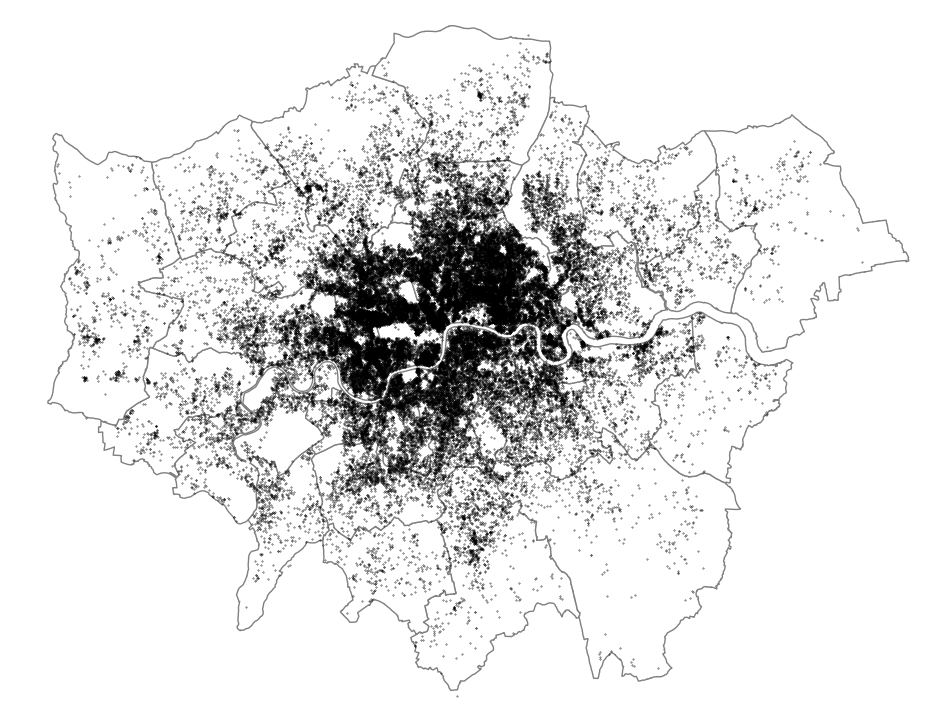

In [150]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot all three to the same axes
London.plot(ax=ax,edgecolor="gray", facecolor="white", linewidth=1)
listings_geo.plot(ax=ax,color="black", alpha=0.9, markersize=0.1)

# Set the limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)
plt.axis('off')

### Identifying "Professional" Listings

The map above gives us an indication of the extent of Airbnb listings in London, it clearly shows that the density of listings is most concentrated in Central London, in close proximity to most tourist attractions. It suggests that the sharing model hasn't provided an even distribution of lisitngs across the city, which could be an indicator of the proffesionalisation of Airbnb properties in London which are responding to a greater demand in these central areas.

However, to truly analyse the impact of Airbnb on the London housing market, we would first want to identify the listings which are possibly acting as professional properties. These properties are:

1. Providing full properties, not just renting out a spare room in an otherwise occupied house.
2. Available for a significant proportion of the year - this would suggest the hosts are not renting out the property they live in.
3. Rented out by hosts with multiple listings - this would suggest the property is either managed by a property management company or a proffesional landlord. 
4. Licensing: In order to rent out a property for more than 90 days a year you need a license


### 1. Filtering for entire homes

Airbnb allows for three types of properties: 
* Entire home/apt
* Private room 
* Shared room 
* Hotel rooms

For this analysis, we will only look at listings which are rented out as entire properties.This is because private rooms and shared rooms are much more likely to be in properties in which the host lives permanently. 

We will be dropping hotel rooms because these are rooms that are listed on airbnb by hotels - these are for a fact hotels and operate as such, which means they should not be included  

In [151]:
#Make the listings object the geodataframe to simplify plotting
listings=listings_geo

In [153]:
# Let's look at the distribution of property type in london - for that we want to make a barchart 
# We want to group by property type and then add them to get a count for each 
#First drop the hotel rooms- we're not going to include them in further analysis
listings = listings[listings.room_type != "Hotel room"]
print(f"Listings data frame is now {listings.shape[0]:,} x {listings.shape[1]}")

# We want to get the count for each room type
roomtype= listings['room_type'].value_counts().to_frame()


Listings data frame is now 76,408 x 17


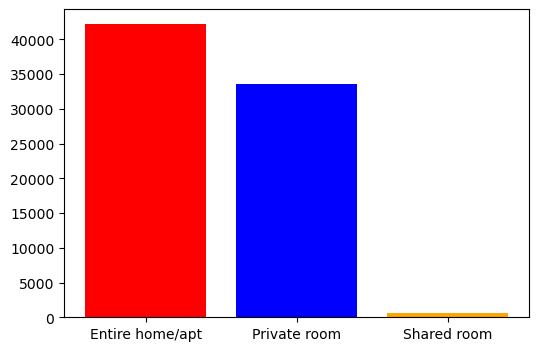

In [154]:
#Create a bar plot 
fig, ax, plt.subplots(1,1, figsize=(6,4))
plt.style.use('seaborn-colorblind')
ax= plt.bar(roomtype.index,roomtype.room_type, color=['red', 'blue', 'orange'])

(501000.0, 563000.0, 155000.0, 202000.0)

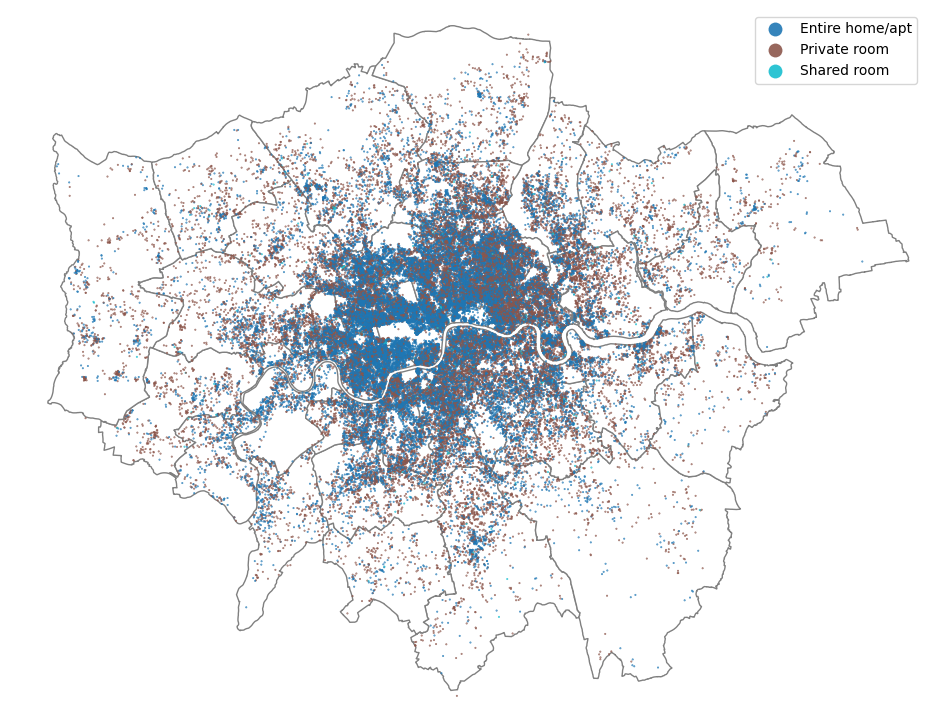

In [156]:
#It might be interesting to look at the spatial distribution of the room types - to see if there's a pattern

fig, ax = plt.subplots(1,1, figsize=(12,9))

color_mapping = {"Entire home/apt": "red", "Private room": "blue", "Shared room": "purple"}

# Plot both to the same axes
London.plot(ax=ax,edgecolor="gray", facecolor="white", linewidth=1)
listings.plot(ax=ax,column="room_type", alpha=0.9, markersize=0.2, categorical=True, legend=True)

# Set the limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)
plt.axis('off')

In [157]:
### For now, let's filter out the shared and private rooms -the most important thing we want to look at is entire homes rooms
entireHomes = listings[listings.room_type == "Entire home/apt"]
print(f"Listings data frame is now {listings.shape[0]:,} x {listings.shape[1]}")


Listings data frame is now 76,408 x 17


The data set has almost halfed by filtering out and only looking at entire homes

Let's map it! Just for fun


(501000.0, 563000.0, 155000.0, 202000.0)

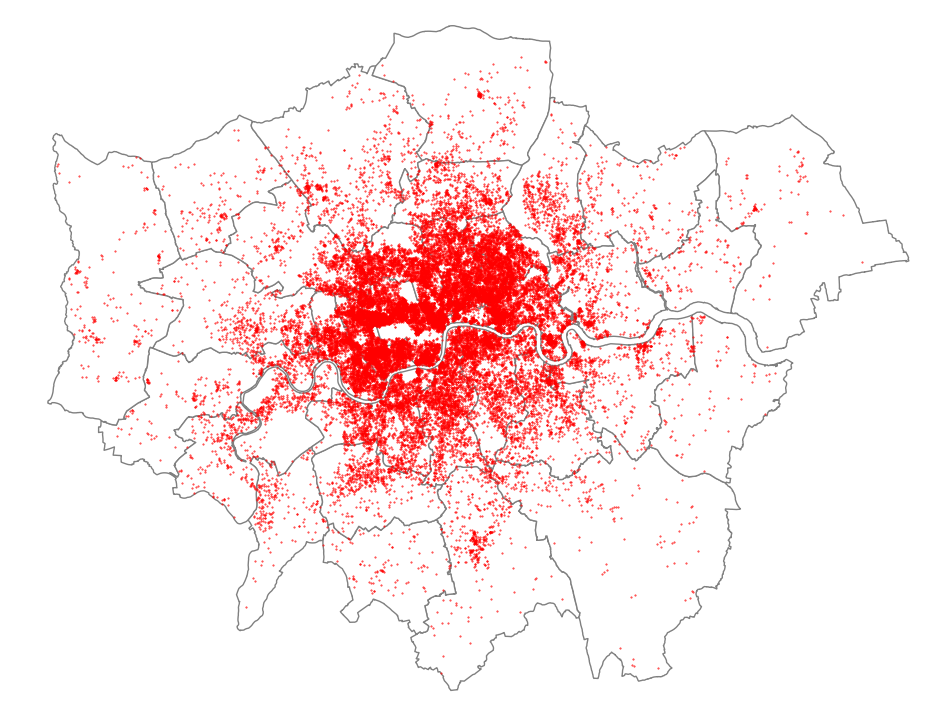

In [160]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot both to the same axes
London.plot(ax=ax,edgecolor="gray", facecolor="white", linewidth=1)
entireHomes.plot(ax=ax,color="red", alpha=0.9, markersize=0.2)

# Set the limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)
plt.axis('off')

Now that we've identified the entire homes, we want to look at the other two factors we've identified: 
* High availability
* Multiple hosts

### Availability


In [159]:
#Let's plot the availability of the property in the last 12 month

(501000.0, 563000.0, 155000.0, 202000.0)

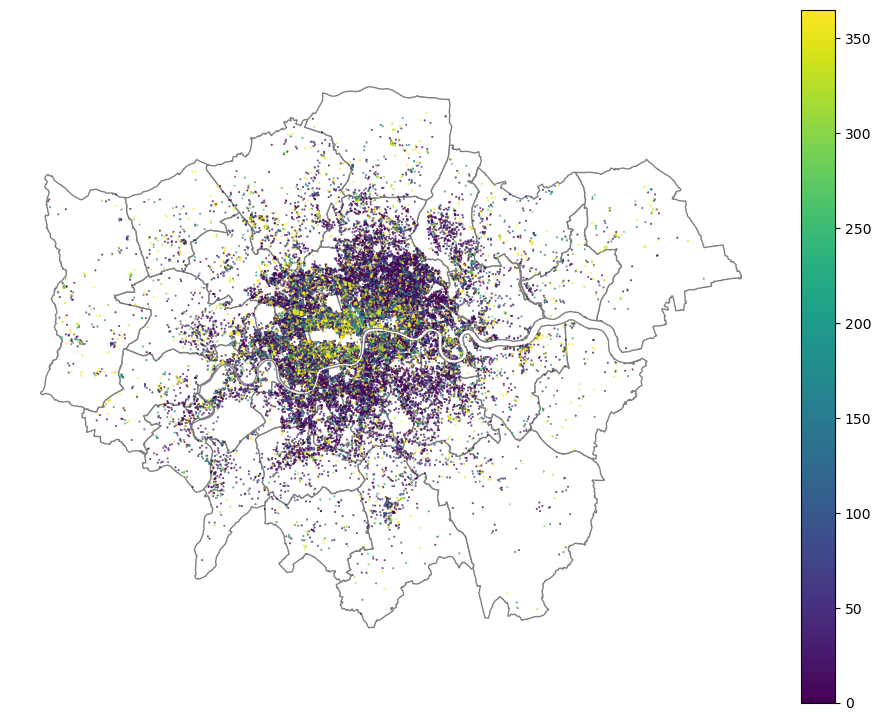

In [162]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot both to the same axes
London.plot(ax=ax,edgecolor="gray", facecolor="white", linewidth=1)
entireHomes.plot(ax=ax,column="availability_365", alpha=0.9, markersize=0.2,legend=True)

# Set the limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)
plt.axis('off')